## Filesystem Access

In [1]:
from pathlib import Path

In [2]:
import sys
GOOGLE_COLAB = 'google.colab' in sys.modules

if GOOGLE_COLAB:
    # Access google drive
    from google.colab import drive
  
    root = '/content/drive'
    drive.mount(root)
    path = f'{root:s}/My Drive/Colab Notebooks/'
else:
    # Access local drive
    
    path = Path('~/Data/Notebooks/').expanduser()
    path.mkdir(mode=0o700, parents=True, exist_ok=True) # Explain this
    path = str(path)
    if path[-1] != '/':
        # Just avoiding an error
        # We need that last '/'
        path = path + '/'

## Configuration

config is a dictionary stored in a json file

    # config example
    config['coefficients'] = {'a0': 1.2, 'a1': -1.2, 'a2': 2', 'b1': -1.0}
    config['output.dirname'] = 'ex-1'

In [3]:
import json

config_filename = path + 'config.json' 

def read_config(config_filename):
    config = None
    with open(config_filename, 'r') as data:
        config = json.load(data)
    return config

def save_config(config, config_filename):
    with open(config_filename, 'w') as data:
        json.dump(config, data)
        
def create_config_example(config_filename):
    config = {}
    config['coefficients'] = {'a0': 1.2, 'a1': -1.2, 'a2': 2, 'b1': -1.0}
    config['output.dirname'] = 'ex-1'
    save_config(config, config_filename)

## Get parameter values from config

In [4]:
def get_config_values(config):
    coefficients = None
    output_dirname = None
    try:
        coefficients = config['coefficients']
    except KeyError:
        raise DemoError(f'No coefficients {str(config):s})')
    try:
        a0 = coefficients['a0']
        a1 = coefficients['a1']
        a2 = coefficients['a2']
        b1 = coefficients['b1']
    except KeyError:
        raise DemoError(f'Bad coefficients: {str(coefficients):s}')
    try:
        output_dirname = config['output.dirname']
    except KeyError:
        raise DemoError(f'No output.dirname')
    return a0, a1, a2, b1, output_dirname

We want to evaluate the difference equation

    y[n] = a0 * x[n] + a1 * x[n - 1] + a2 * x[n - 2] + b1 * y[n - 1]
    
with the initial value
    
    y[0] = 1
    
and

    x[n] = 0 for n < 0
    
for 

    0 <= n < 1000
    
and

    x[n] = sin(2 * pi / 20)
    
The output (the values x[n], y[n], some graphics and a markdown file with the report) must be saved in a directory
with dirname equal to config['output.dirname']


In [5]:
import numpy as np

In [6]:
def get_n(max_n):
    return np.arange(max_n)

def get_x(n):
    return np.sin(2 * np.pi * n / 20)

In [7]:
def get_y(n, x, a0, a1, a2, b1, y0, max_n):
    y = np.zeros_like(x)
    n = 0
    y[0] = y0
    x2 = 0.0   # x[-2] == 0.0
    x1 = 0.0   # x[-1] == 0.0
    x0 = x[0]  # x[0] == sin(2 * pi * 0 / 20)
    for n in np.arange(1, max_n):
        x2 = x1
        x1 = x0
        x0 = x[n]
        y[n] = a0 * x0 + a1 * x1 + a2 * x2 + b1 * y[n-1]
    return y

In [8]:
# Hack: I don't want to create the config file manually.
# So, I include this line of code
create_config_example(config_filename)
# /Hack

In [9]:
config = read_config(config_filename)
a0, a1, a2, b1, output_dirname = get_config_values(config)
max_n = 1000
n = get_n(max_n)
x = get_x(n)
y0 = 1.0
y = get_y(n, x, a0, a1, a2, b1, y0, max_n)

In [10]:
config_filename

'/home/dberns/Data/Notebooks/config.json'

In [11]:
output_dirname

'ex-1'

## Output

In [12]:
output_dir = Path(path, output_dirname)
output_dir.mkdir(mode=0o700, parents=True, exist_ok=True) # Explain this
print(output_dir)

/home/dberns/Data/Notebooks/ex-1


## Graphics

In [13]:
import matplotlib.pyplot as plt

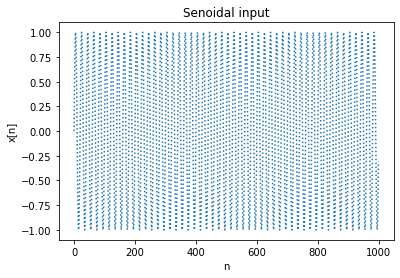

In [14]:
plt.plot(n, x, ':')
plt.title('Senoidal input')
plt.xlabel('n')
plt.ylabel('x[n]')
plt.savefig(Path(output_dir, 'alpha.png'))

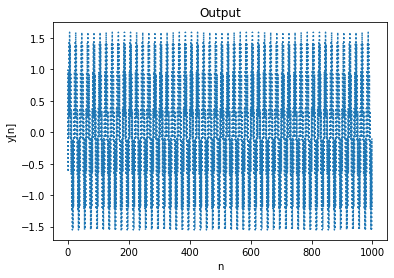

In [15]:
plt.plot(n, y, ':')
plt.title('Output')
plt.xlabel('n')
plt.ylabel('y[n]')
plt.savefig(Path(output_dir, 'bravo.png'))

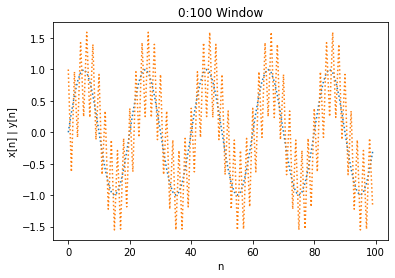

In [16]:
plt.plot(n[0:100], x[0:100], ':', n[0:100], y[0:100], ':')
plt.title('0:100 Window')
plt.xlabel('n')
plt.ylabel('x[n] | y[n]')
plt.savefig(Path(output_dir, 'charlie.png'))

## CSV file

### How to create a csv file

In [17]:
newline = '\n'
csv_filename = Path(output_dir, 'demo.csv')
headers = ['n', 'x', 'y']
with open(csv_filename, 'w') as csv_file:
    line = ','.join(headers) + newline
    csv_file.write(line)
    for k in range(max_n):
        values = [n[k], x[k], y[k]]
        line = ','.join([str(v) for v in values]) + newline
        csv_file.write(line)

### How to read a csv file with module csv (included with python)

In [18]:
import csv

In [19]:
with open(csv_filename, newline=newline, mode='r') as csv_file:
    spamreader = csv.reader(csv_file, delimiter=',')
    for row in spamreader:
        print(', '.join(row))

n, x, y
0, 0.0, 1.0
1, 0.3090169943749474, -0.6291796067500631
2, 0.5877852522924731, 0.963701516251094
3, 0.8090169943749475, -0.08018943700223014
4, 0.9510565162951535, 1.4262073678914238
5, 1.0, 0.250558801304287
6, 0.9510565162951536, 1.5928220508402045
7, 0.8090169943749475, 0.23673052285554808
8, 0.5877852522924732, 1.3999044192357901
9, 0.3090169943749475, -0.11639233998692622
10, 1.2246467991473532e-16, 0.921142451321936
11, -0.3090169943749469, -0.6739288558219774
12, -0.587785252292473, 0.3394069463209462
13, -0.8090169943749473, -1.222919025569809
14, -0.9510565162951535, -0.1230989053193845
15, -1.0, -1.553667263876326
16, -0.9510565162951536, -0.2897135882681654
17, -0.8090169943749476, -1.5398389854275873
18, -0.5877852522924734, -0.09679595666375085
19, -0.3090169943749476, -1.1867161225851135
20, -2.4492935982947064e-16, 0.38196601125010365
21, 0.3090169943749472, -0.629179606750062
22, 0.5877852522924721, 0.9637015162510915
23, 0.8090169943749472, -0.08018943700222703


### How to read a csv file with package pandas

In [20]:
import pandas as pd

In [21]:
dataframe = pd.read_csv(csv_filename)
dataframe

,n,x,y
0,0,0.000000,1.000000
1,1,0.309017,-0.629180
2,2,0.587785,0.963702
3,3,0.809017,-0.080189
4,4,0.951057,1.426207
...,...,...,...
995,995,-1.000000,-1.553667
996,996,-0.951057,-0.289714
997,997,-0.809017,-1.539839
998,998,-0.587785,-0.096796


## Report

In [22]:
report_filename = Path(output_dir, 'report.md') # Markdown file
alpha_filename = str(Path(output_dir, 'alpha.png'))
bravo_filename = str(Path(output_dir, 'bravo.png'))
charlie_filename = str(Path(output_dir, 'charlie.png'))
with open(report_filename, 'w') as report:
    report.write('# Report: discrete time dynamical system simulation' + newline)
    report.write(newline)
    report.write('## Figures' + newline)
    report.write(newline)
    report.write(f'![Alpha]({alpha_filename:s})' + newline)
    report.write(newline)
    report.write(f'![Bravo]({bravo_filename:s})' + newline)
    report.write(newline)
    report.write(f'![Charlie]({charlie_filename:s})' + newline)
    

In [24]:
n.shape[0]

1000